**This Notebook will run on an Amazon Web Services p2.8xlarge ubuntu deep learning machine with GPU**

### This book will solve a binary classification problem, specifially looking to classify whether a skin anomaly is benign(0) or malignant(1)
- There is a multiclass problem in a different book, designed to classify specific type of skin anomaly into 7 classes.
- This book is similar to the multiclass book, but the target has changed, as has some of the parameters of the model.

In [2]:
#!pip install progressbar

In [3]:
#imports
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

from progressbar import ProgressBar

from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [9]:
#Loading the full DataFrame of dummy columns and categorical data (y)
main = pd.read_csv('./main.csv', index_col = 'Unnamed: 0')

In [10]:
main.head()

,image,NV,BKL,VASC,DF,MEL,BCC,AKIEC,Category,Malignant
0,ISIC_0024306,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,ISIC_0024307,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,ISIC_0024308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,ISIC_0024309,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,ISIC_0024310,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,1


In [11]:
main.shape

(10015, 10)

In [163]:
#Loading all 10015 images (X)

#Creating a 4 dimensional array of zeros to later overwrite with image data.

bar = ProgressBar()

images=np.zeros((10015,112,150,3))     #Number of total images, 
                                        #pixel dimension height, pixel dimension width, 3 layers(RGB)

for i in bar(range(0,main.shape[0])):
    n=24306+i
    x = ndimage.imread(f'./data/ISIC2018_Task3_Training_Input/ISIC_00{n}.jpg')
    images[i,:,:,:] = imresize(x, .25)

100% |########################################################################|


In [164]:
#This is to scale, turning each shade of red, green, blue (layer) into a value between 0 and 1
bar = ProgressBar()
images = [image/255 for image in bar(images)]

100% |########################################################################|


------------

In [165]:
main.Malignant.value_counts()

0    8061
1    1954
Name: Malignant, dtype: int64

In [240]:
mal = main[main.Malignant == 0].sample(n = 5000)

In [243]:
benign = main[main.Malignant == 1].sample(5000, replace=True)

In [244]:
master = pd.concat([mal, benign], axis = 0)

In [245]:
master.shape

(10000, 10)

In [246]:
master.index

Int64Index([1102, 1545, 2158, 3061, 1172, 9007, 5935,  134, 7784, 4247,
            ...
            4886, 5239, 6750, 5839, 5160, 5235, 4694, 1183, 9788, 1310],
           dtype='int64', length=10000)

In [247]:
samp_images = []
for n in master.index:
    samp_images.append(images[n])

In [248]:
master.head()

,image,NV,BKL,VASC,DF,MEL,BCC,AKIEC,Category,Malignant
1102,ISIC_0025408,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1545,ISIC_0025851,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
2158,ISIC_0026464,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3061,ISIC_0027367,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
1172,ISIC_0025478,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [249]:
master['picture'] = samp_images

In [250]:
master.head()

,image,NV,BKL,VASC,DF,MEL,BCC,AKIEC,Category,Malignant,picture
1102,ISIC_0025408,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,"[[[0.96862745098, 0.670588235294, 0.7215686274..."
1545,ISIC_0025851,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2158,ISIC_0026464,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,"[[[0.96862745098, 0.674509803922, 0.7215686274..."
3061,ISIC_0027367,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,"[[[0.819607843137, 0.725490196078, 0.709803921..."
1172,ISIC_0025478,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,"[[[0.921568627451, 0.607843137255, 0.639215686..."


In [251]:
#train_test_split

X = np.asarray(samp_images, dtype=np.float32)
y = master.Malignant

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.75)

#### Topography of Network

In [259]:
#Binary

model = Sequential()


#Convolution 1
model.add(Conv2D(50,3,3,input_shape=(112,150,3)))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(3,3)))

#Convolution 2
model.add(Conv2D(100,2,2))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2)))

#Convolution 3
model.add(Conv2D(200,2,2))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2)))

#Convolution 4
model.add(Conv2D(400,3,3))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(3,3)))

#Flatten
model.add(Flatten())

#Last layer          
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

#Much of this layout was adapted from 2 outside sources, listed in the footnotes as [1][2]

In [260]:
#Model loss switched to binary crossentropy
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [197]:
#early = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='auto')

In [291]:
history = model.fit(X_train, y_train, epochs=100, verbose=1,
                    batch_size = 50,
                    validation_data=(X_test, y_test))

In [262]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [263]:
final_binary_model_history = pd.DataFrame(history.history)

In [264]:
final_binary_model_history.head()

,val_loss,val_acc,loss,acc
0,0.577926,0.6988,0.618141,0.645467
1,0.650113,0.6636,0.589080,0.661333
2,0.572936,0.6948,0.575887,0.693600
3,0.556069,0.7264,0.525047,0.719733
4,0.487923,0.7556,0.496628,0.740000


In [265]:
final_binary_model_history.tail()

,val_loss,val_acc,loss,acc
95,0.389823,0.9108,0.027971,0.991600
96,0.471839,0.9004,0.049814,0.983867
97,0.520791,0.9008,0.017394,0.994133
98,0.408703,0.9068,0.042145,0.985600
99,0.440795,0.9016,0.024217,0.992533


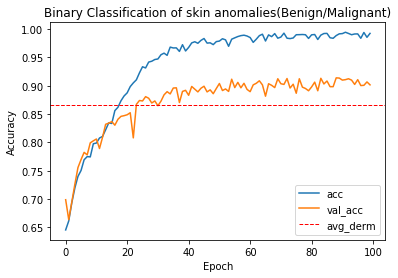

In [279]:
plt.plot(history.history['acc'], label = 'acc')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.axhline(y=0.866, linewidth=1, color='r', linestyle = '--', label = 'avg_derm')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Binary Classification of skin anomalies(Benign/Malignant)');
# [3]

In [276]:
score = model.evaluate(X_test, y_test, verbose=0)
labels = model.metrics_names

In [277]:
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

loss: 0.440795397341
acc: 0.9016


In [283]:
test_preds = model.predict_classes(X_test)

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 1076
False Positives: 196
False Negatives: 78
True Positives: 1150


In [292]:
specificity = tp/(tp+fn)
specificity

0.93648208469055372

In [284]:
from sklearn.metrics import roc_auc_score, roc_curve

In [285]:
roc_auc_score(y_test, test_preds)

0.89119701718804423

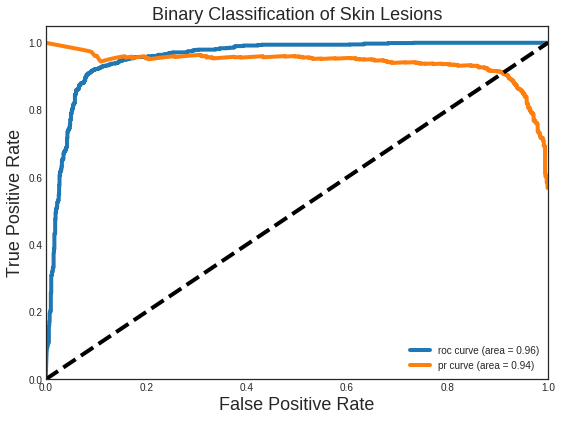

In [293]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
plt.style.use('seaborn-white')

# Y_score = logreg_gs.best_estimator_.decision_function(X_test)
y_score = model.predict_proba(X_test)

# For class 1, find the area under the curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(y_test, y_score)
pr_auc = auc(rec, prec)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[9,6.5])
plt.plot(fpr, tpr, label='roc curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot(rec, prec, label='pr curve (area = %0.2f)' % pr_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Binary Classification of Skin Lesions', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### [4]

---------

#### Footnotes

[1] 'Build a convolutional neural network in 11 lines http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/ <br>
[2] 'Show me the Monet' http://res.cloudinary.com/general-assembly-profiles/image/upload/v1467305840/jeypsq559sd5ak79ayc0.pdf , project by GA graduate, Samuel Bozek - SF <br>
[3] Note that the baseline for human doctors included other images, as well as the images in the HAM10000 set. <br>
[4] Code for roc_auc_visualization adapted from Adam Blomberg - NYC, from his instruction in dsi-plus3-nyc.  Info gathered from slack